In [1]:
import os
import pandas as pd
import numpy as np
# Read CSV file
df = pd.read_csv("student_depression_dataset.csv")
data = df.copy()

# Drop id (id will not affect the prediction)
data = data.drop(columns=['id'])

# Sleep Duration text and map to numeric
data['Sleep Duration'] = data['Sleep Duration'].astype(str).str.strip("'\" ")
sleep_map = {
    'Less than 5 hours': 5.0,
    '5-6 hours': 5.5,
    '6-7 hours': 6.5,
    '7-8 hours': 7.5,
    'More than 8 hours': 8.0,
    'Others': np.nan
}
data['Sleep Hours'] = data['Sleep Duration'].map(sleep_map)
data = data.drop(columns=['Sleep Duration'])

# Convert Financial stress and Age into numeric (their type may be object)
data['Financial Stress'] = pd.to_numeric(data['Financial Stress'], errors='coerce')
data['Age'] = pd.to_numeric(data['Age'], errors='coerce')


In [2]:
# Depression as the predict target and other features as predictors
Y = "Depression"
X = data.drop(columns=[Y])
y = data[Y]
numeric_features = [
    "Age",
    "Sleep Hours",
    "Academic Pressure",
    "Work Pressure",
    "CGPA",
    "Study Satisfaction",
    "Job Satisfaction",
    "Work/Study Hours",
    "Financial Stress",
]
categorical_features = [
    "Gender",
    "City",
    "Dietary Habits",
    "Degree",
    "Have you ever had suicidal thoughts ?",
    "Family History of Mental Illness",
]

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Median imputation then standard scaling
numeric_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler()),
])
# One-hot encoding is important for svm model
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop=None, sparse_output=False)),
])
# Make a preprocessor to combine the numeric and categorical transformers 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ]
)
# Remark: The preprocessor will be used to fit on training data and transform both training and test data

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
# Remark: Stratify is used to maintain the same class distribution in both training and test datasets

# Fitting the preprocessor on training data 
preprocessor.fit(X_train)
# The preprocessor will be used to transform both training and test data
X_train_proc = preprocessor.transform(X_train)
X_test_proc = preprocessor.transform(X_test)


In [5]:
# Train Linear SVM 
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
# Build pipeline for SVM model
svm_model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', SVC(kernel='rbf', max_iter=10000, random_state=42, probability=True))
    #Probability is used to calculate the probability of the predicted class
    # The probability is used to calculate the ROC AUC score
])
# Parameters tuning for SVM model(RBF kernel)
params_grid = {
    'model__C': [0.1, 1.0, 10.0],
    'model__gamma': [0.001, 0.01, 0.1, 1.0]
}
grid_search = GridSearchCV(
    svm_model,
    params_grid,
    cv=5,  
    scoring='roc_auc',
    n_jobs=-1, 
    verbose=1
)
grid_search.fit(X_train, y_train)
#Best parameters for the Radial Basis Function SVM model
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")
best_svm = grid_search.best_estimator_
y_pred_train = best_svm.predict(X_train)
y_pred_test = best_svm.predict(X_test)


Fitting 5 folds for each of 12 candidates, totalling 60 fits


/opt/anaconda3/lib/python3.13/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (m

  model__C: 0.1
  model__gamma: 0.01


/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


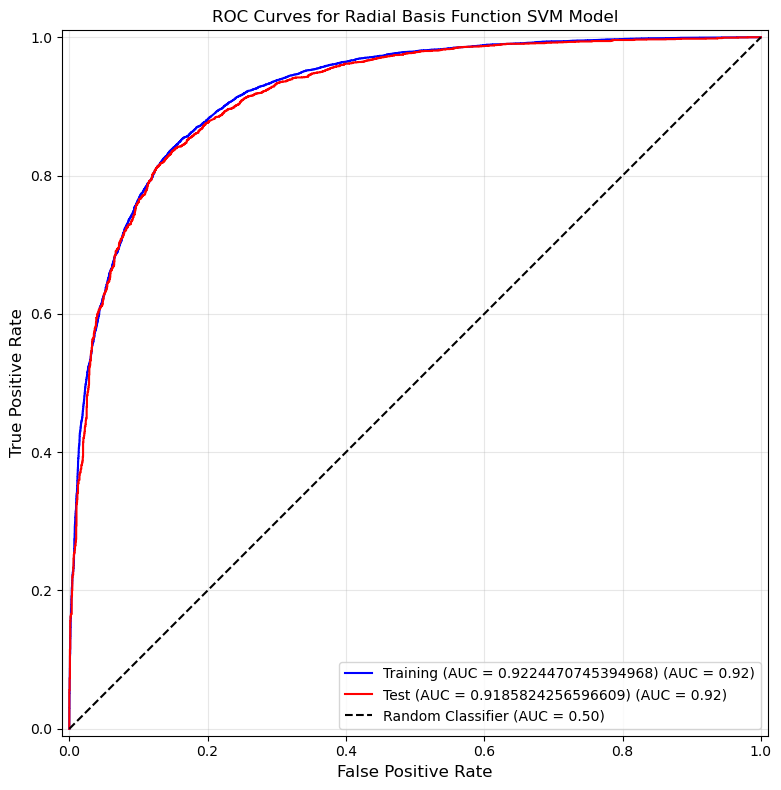

 Training Accuracy: 0.8486
 Test Accuracy: 0.8430
 Training ROC AUC Score: 0.9224470745394968
 Test ROC AUC Score: 0.9185824256596609

Classification report for test dataset:
              precision    recall  f1-score   support

           0       0.83      0.78      0.81      2313
           1       0.85      0.88      0.87      3268

    accuracy                           0.84      5581
   macro avg       0.84      0.83      0.84      5581
weighted avg       0.84      0.84      0.84      5581

Confusion matrix for test dataset:
[[1813  500]
 [ 376 2892]]


In [8]:
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

# Decision function scores
y_scores_train = best_svm.decision_function(X_train)
y_scores_test = best_svm.decision_function(X_test)

# Calculate ROC AUC scores
roc_auc_train = roc_auc_score(y_train, y_scores_train)
roc_auc_test = roc_auc_score(y_test, y_scores_test)

# Plot ROC curves
fig, ax = plt.subplots(figsize=(8, 8))

# Training ROC curve
RocCurveDisplay.from_estimator(
    best_svm, X_train, y_train,
    name=f'Training (AUC = {roc_auc_train})',
    ax=ax,
    color='blue',
)

# Test ROC curve
RocCurveDisplay.from_estimator(
    best_svm, X_test, y_test,
    name=f'Test (AUC = {roc_auc_test})',
    ax=ax,
    color='red',
)
# random classifier
ax.plot([0, 1], [0, 1],
         'k--', 
         label='Random Classifier (AUC = 0.50)'
)

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves for Radial Basis Function SVM Model')
ax.legend(loc='lower right', fontsize=10) #position of the legend 
ax.grid(alpha=0.3) 
plt.tight_layout()
plt.show()

#The result of the Radial Basis Function SVM model
print(f" Training Accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
print(f" Test Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
print(f" Training ROC AUC Score: {roc_auc_train}")
print(f" Test ROC AUC Score: {roc_auc_test}")
print(f'\nClassification report for test dataset:\n{classification_report(y_test, y_pred_test)}')
print(f'Confusion matrix for test dataset:\n{confusion_matrix(y_test, y_pred_test)}')

In [11]:
# Extract the essential component for feature importance and direction analysis
import pandas as pd
import numpy as np
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score
# Get preprocessor and model 
preprocessor = svm_model.named_steps['preprocess']
model = best_svm.named_steps['model']

# Get feature names 
feature_names = preprocessor.get_feature_names_out()

# Transform data
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [12]:
# Calculate permutation importance
perm_importance = permutation_importance(
    model, 
    X_test_transformed, 
    y_test,
    n_repeats=10, #shuffle 10 times for each feature column
    random_state=42,
    scoring='roc_auc',
    n_jobs=-1
)
# The permutation importance calculate the difference in the ROC AUC score when the feature is shuffled
#
importances = perm_importance.importances_mean
importances_std = perm_importance.importances_std

In [13]:
# calculate the mean difference between the depression and no depression group
mean_differences = []
for i, feature_name in enumerate(feature_names):
    feature_values = X_test_transformed[:, i]
    
    # Get feature values for each class
    class_0_values = feature_values[y_test == 0]  # No depression
    class_1_values = feature_values[y_test == 1]  # Depression
    
    # Calculate mean difference: mean(Depression) - mean(No Depression)
    if len(class_0_values) > 0 and len(class_1_values) > 0:
        mean_diff = np.mean(class_1_values) - np.mean(class_0_values)
    else:
        mean_diff = np.nan

    mean_differences.append(mean_diff)
# Determine the direction of the mean difference
direction = []
for i in range(len(mean_differences)):
    if np.array(mean_differences)[i] > 0:
        direction.append('positive')
    else:
        direction.append('negative')

In [ ]:
# Create a dataframe to store the feature importance, sd, and mean difference
feature_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances,
    'importance_std': importances_std,
    'mean_difference': mean_differences,
    'direction':direction
})
# Sort by importance 
feature_df_sorted = feature_df.sort_values('importance', ascending=False).reset_index(drop=True)
# Show the top 15 features
top_n = 10
df = feature_df_sorted.head(top_n)[['feature', 'importance', 'mean_difference', 'direction']].copy()
print(df.to_string(index=False))

                                       feature  importance  mean_difference direction
                        num__Academic Pressure    0.089012         0.953097  positive
                         num__Financial Stress    0.036165         0.701897  positive
cat__Have you ever had suicidal thoughts ?_Yes    0.024944         0.538305  positive
 cat__Have you ever had suicidal thoughts ?_No    0.024944        -0.538305  negative
                                      num__Age    0.015668        -0.449408  negative
                         num__Work/Study Hours    0.009673         0.421421  positive
                       num__Study Satisfaction    0.005944        -0.353486  negative
                 cat__Dietary Habits_Unhealthy    0.003715         0.186382  positive
                   cat__Dietary Habits_Healthy    0.002669        -0.142874  negative
                              num__Sleep Hours    0.001444        -0.166382  negative


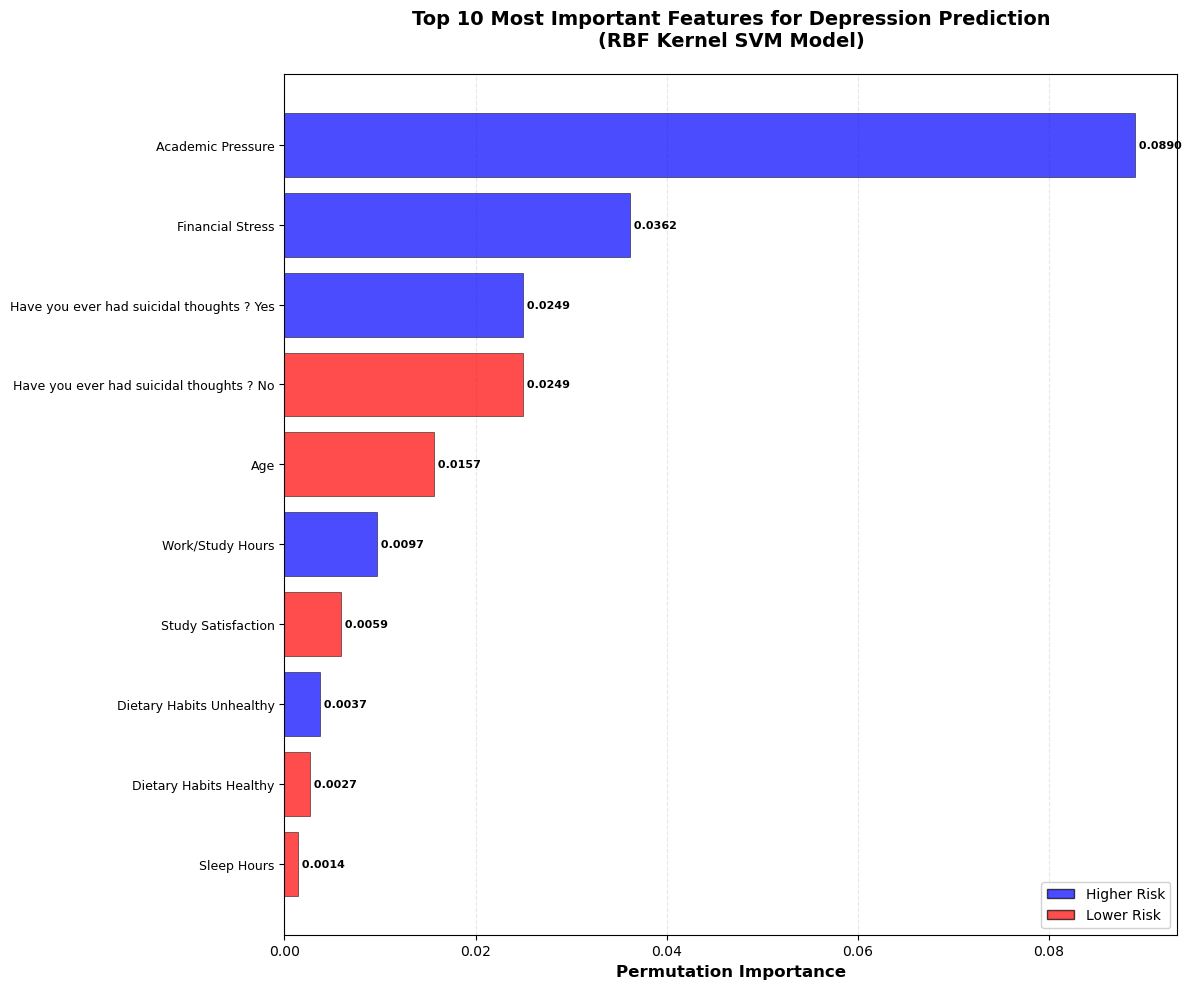

In [15]:
# Visualize Feature Importance
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

top_n = 10
top_df = feature_df_sorted.head(top_n).copy()
# Replace the feature name with the clean name
top_df['clean_name'] = top_df['feature'].str.replace('cat__', '').str.replace('num__', '').str.replace('_', ' ')
# Determine the color of the bar
top_df['color'] = top_df['mean_difference'].apply(lambda x: 'blue' if (not np.isnan(x) and x > 0) else 'red')


fig, ax = plt.subplots(figsize=(12, 10))
# Plot the bar
bars = ax.barh(range(len(top_df)), top_df['importance'], color=top_df['color'], alpha=0.7, edgecolor='black', linewidth=0.5)
ax.set_yticks(range(len(top_df)))
ax.set_yticklabels(top_df['clean_name'], fontsize=9)

# Create the text for the bar
for i, (bar, row) in enumerate(zip(bars, top_df.itertuples())):
    ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f' {row.importance:.4f}', 
            ha='left', va='center', fontsize=8, fontweight='bold')

# Invert the y-axis
ax.invert_yaxis()
# Set the x-axis label
ax.set_xlabel('Permutation Importance', fontsize=12, fontweight='bold')
# Set the y-axis label
ax.set_title(f'Top {top_n} Most Important Features for Depression Prediction\n(RBF Kernel SVM Model)', 
             fontsize=14, fontweight='bold', pad=20)
# Add the grid
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)
# Add the legend
legend_elements = [
    Patch(facecolor='blue', alpha=0.7, edgecolor='black', label='Higher Risk'),
    Patch(facecolor='red', alpha=0.7, edgecolor='black', label='Lower Risk')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10, framealpha=0.9)

plt.tight_layout()
plt.show()